## Demand Forecasting Pipeline
<b> Day 1: Setting up basics for forecasting pipeline

In [32]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

In [33]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

### Reading in Data
Sales dataset from kaggle from Favorita stores in Ecuador. (ref: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data?select=train.csv)

In [34]:
df = pd.read_csv('store_data.csv')
df.columns = df.columns.str.replace(' ', '_').str.lower()

df['date'] = pd.to_datetime(df['date'], format= "%Y/%m/%d")

In [35]:
min(df['date']), max(df['date'])

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [36]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


Let's aggregate the dataset to the "family" and "sales" daily level so that we can have high volume metrics for demand forecasting throughout the country. The line of code below can also be done in SQL.
<i>select date,
        family, 
        sum(sales)
from df
group by date, family
</i>

In [37]:
agg_df = df.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])

In [38]:
agg_df.head()

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.00
33,2013-01-02,AUTOMOTIVE,255.00
66,2013-01-03,AUTOMOTIVE,161.00
99,2013-01-04,AUTOMOTIVE,169.00
132,2013-01-05,AUTOMOTIVE,342.00


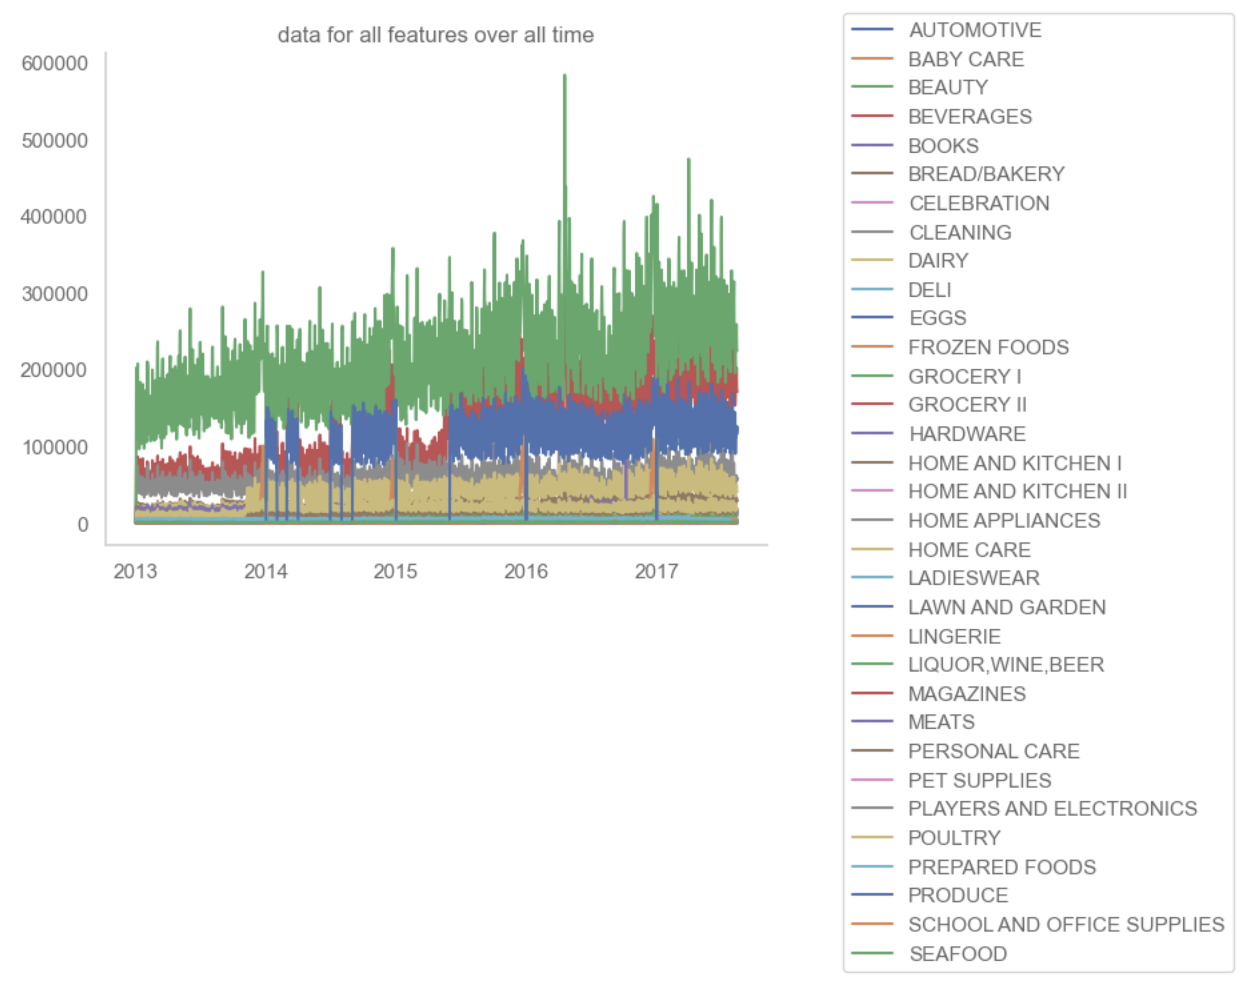

In [39]:
total_sales_df = agg_df.pivot(index='date',columns='family', values='sales')
total_sales_df.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,EGGS,FROZEN FOODS,GROCERY I,GROCERY II,HARDWARE,HOME AND KITCHEN I,HOME AND KITCHEN II,HOME APPLIANCES,HOME CARE,LADIESWEAR,LAWN AND GARDEN,LINGERIE,"LIQUOR,WINE,BEER",MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.00,0.00,2.00,810.00,0.00,180.59,0.00,186.00,143.00,71.09,46.00,29.65,700.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,5.00,105.00,0.00,110.80,25.00,0.00,0.00,42.64,37.85,0.00,0.00,0.00
2013-01-02,255.00,0.00,207.00,72092.00,0.00,26246.32,0.00,74629.00,23381.00,15754.50,10932.00,7115.39,202020.00,1476.00,46.00,0.00,0.00,21.00,0.00,0.00,121.00,469.00,2411.00,0.00,20871.46,17204.00,0.00,0.00,13975.88,5338.11,0.00,0.00,1526.75
2013-01-03,161.00,0.00,125.00,52105.00,0.00,18456.48,0.00,55893.00,18001.00,11172.45,7358.00,4760.81,144878.00,1048.00,37.00,0.00,0.00,15.00,0.00,0.00,83.00,366.00,2476.00,0.00,16597.40,12568.00,0.00,0.00,10674.39,3591.39,0.00,0.00,1094.31
2013-01-04,169.00,0.00,133.00,54167.00,0.00,16721.97,0.00,52064.00,18148.00,10143.21,6760.00,4525.93,135754.00,1031.00,57.00,0.00,0.00,13.00,0.00,0.00,127.00,382.00,4796.00,0.00,21625.96,11303.00,0.00,0.00,10772.52,4472.97,0.00,0.00,1293.12
2013-01-05,342.00,0.00,191.00,77818.00,0.00,22367.76,0.00,70128.00,23082.00,13734.95,8576.00,5781.61,188356.00,1273.00,87.00,0.00,0.00,11.00,0.00,0.00,180.00,458.00,6715.00,0.00,20879.09,16819.00,0.00,0.00,13475.01,5830.07,0.00,0.00,1245.64


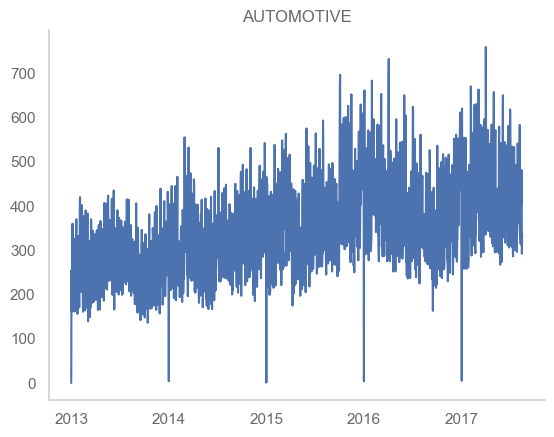

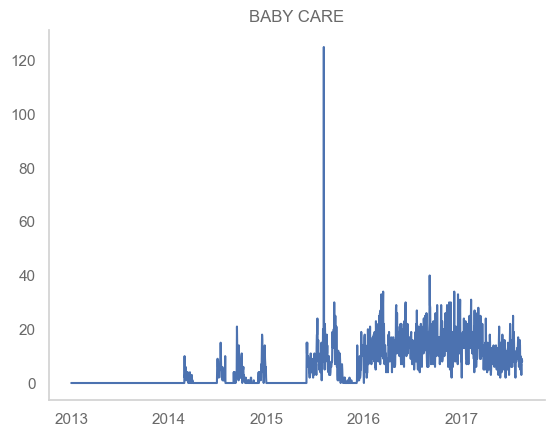

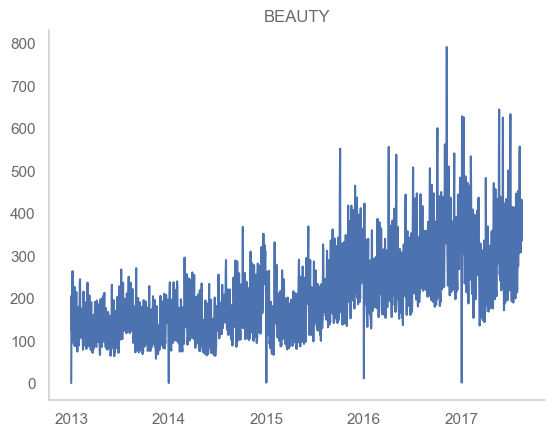

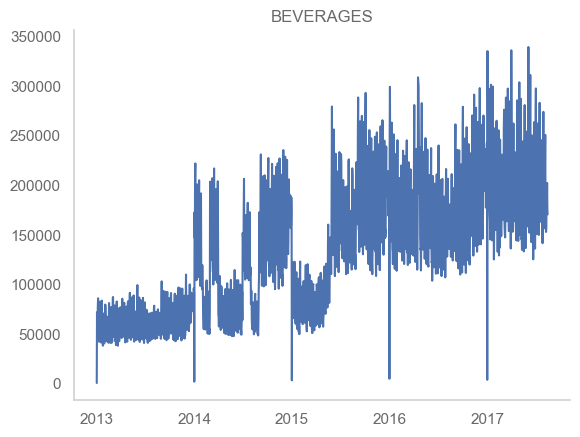

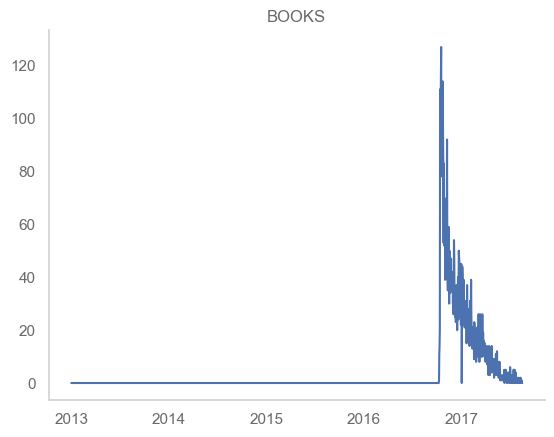

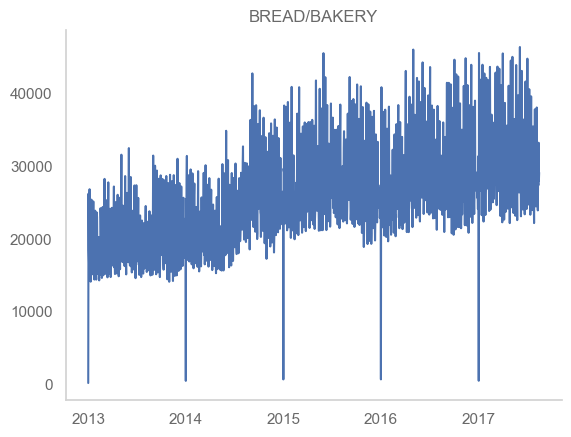

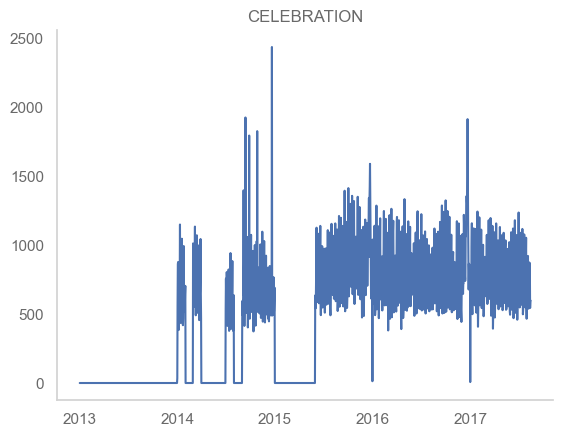

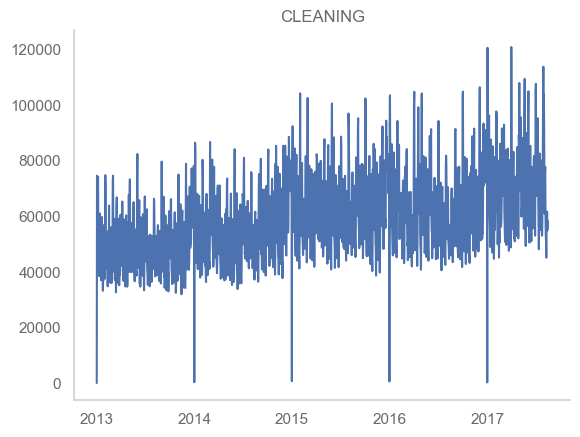

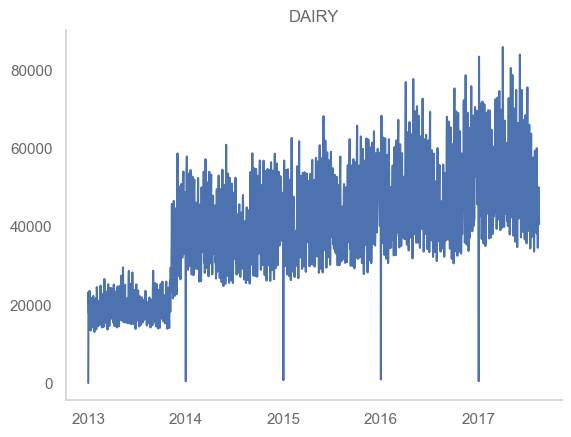

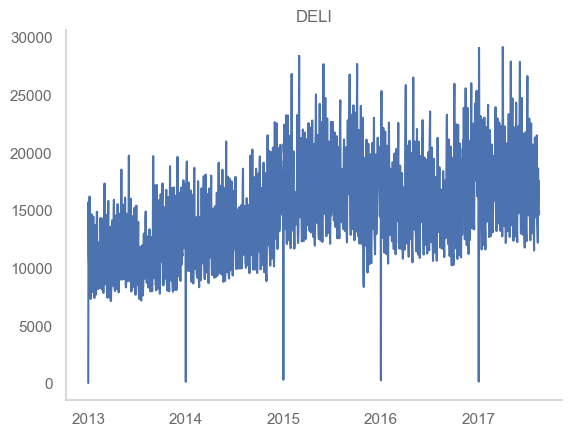

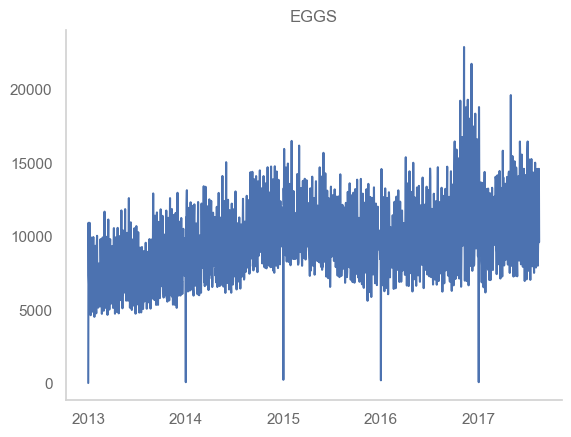

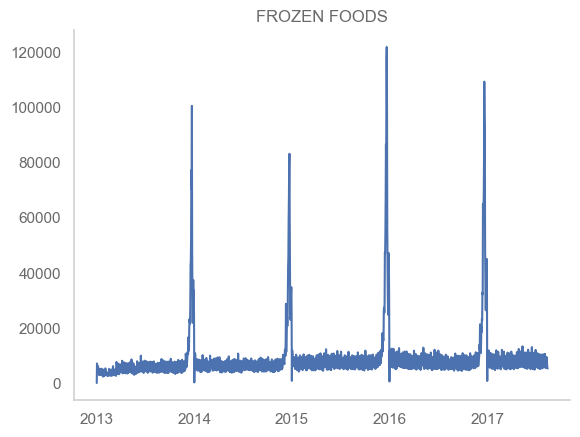

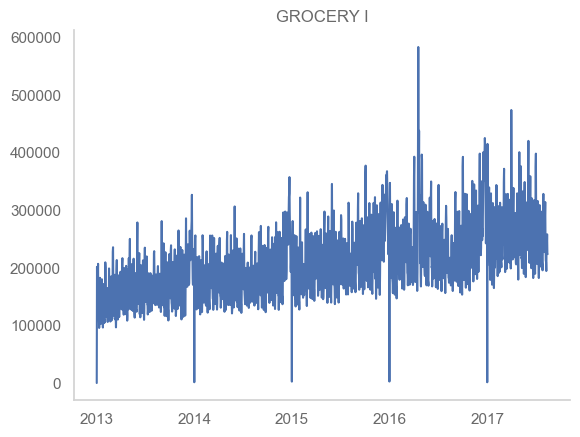

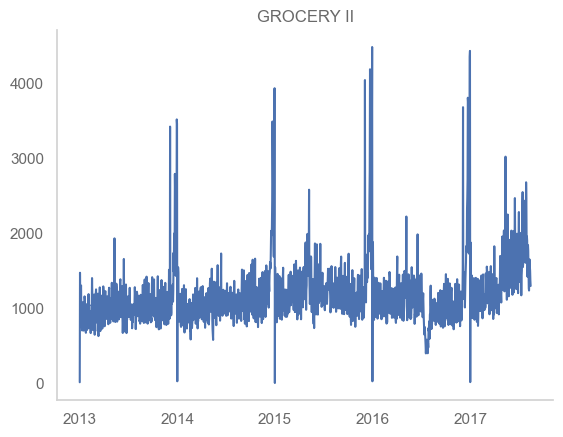

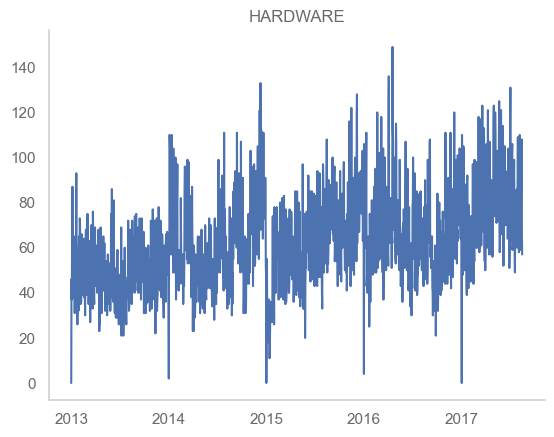

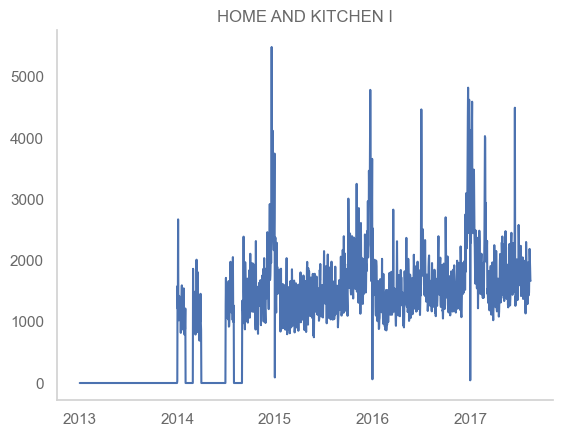

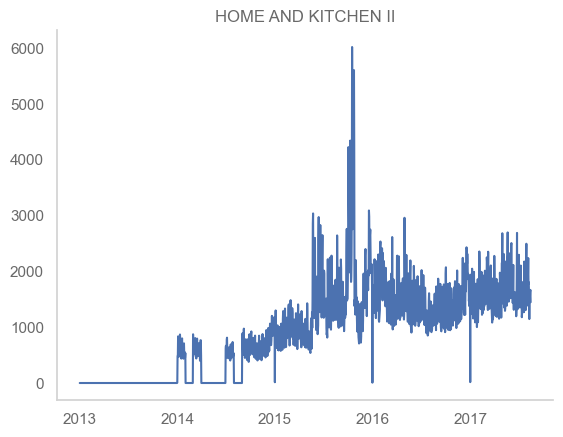

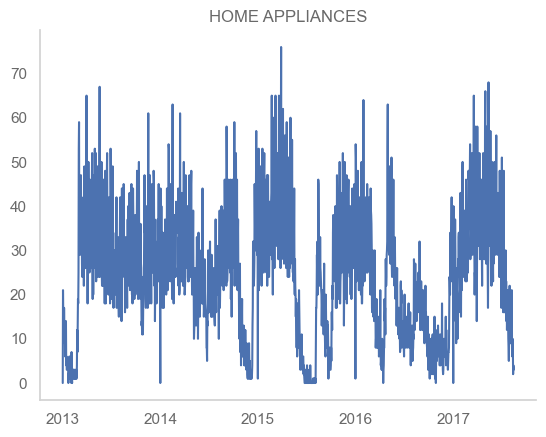

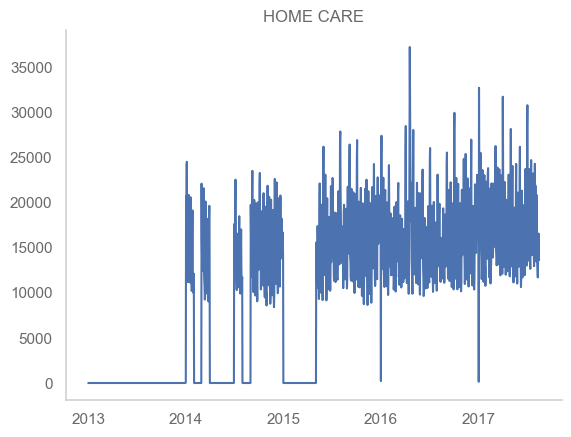

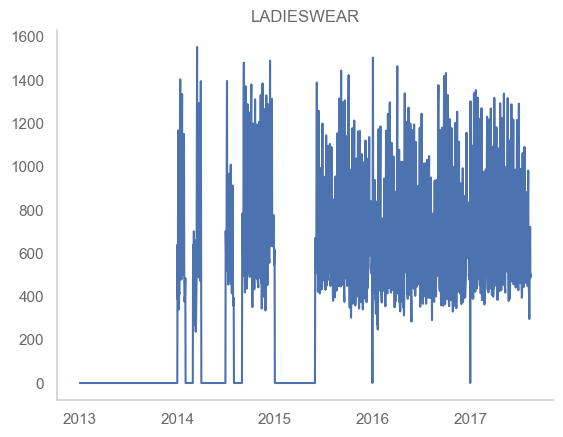

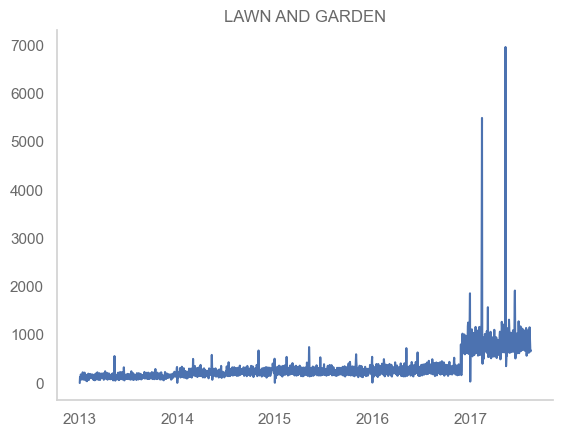

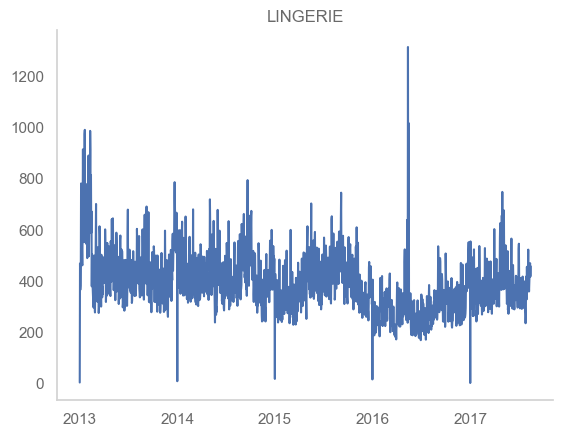

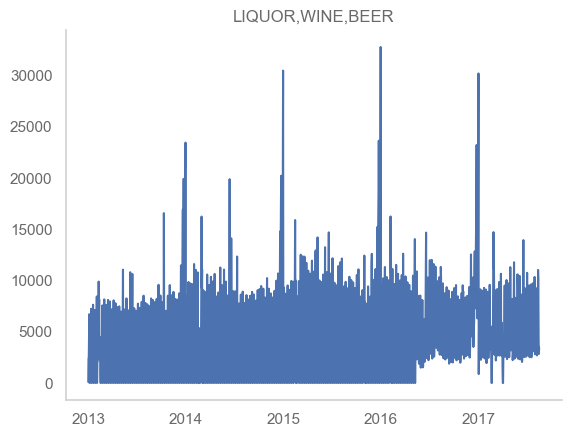

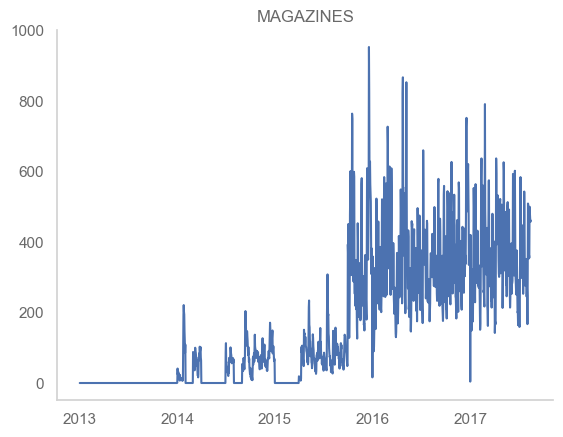

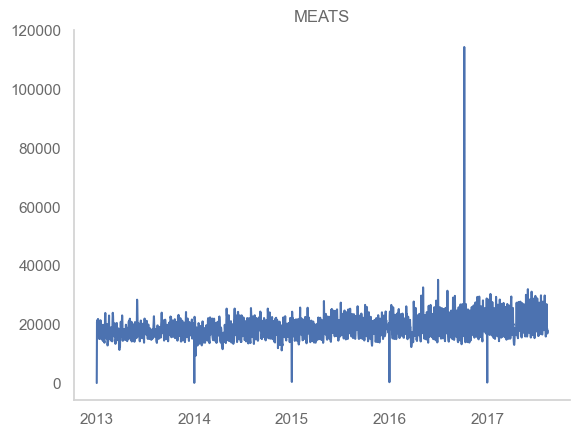

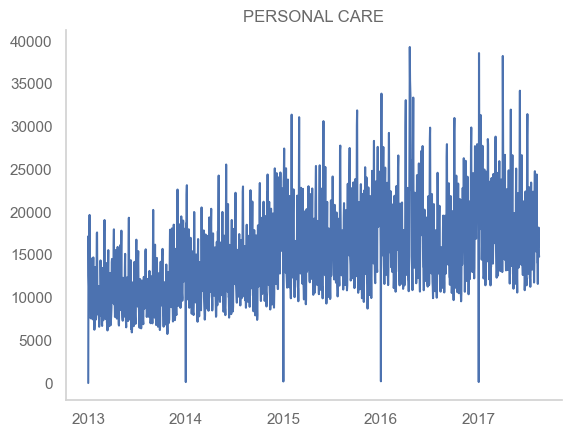

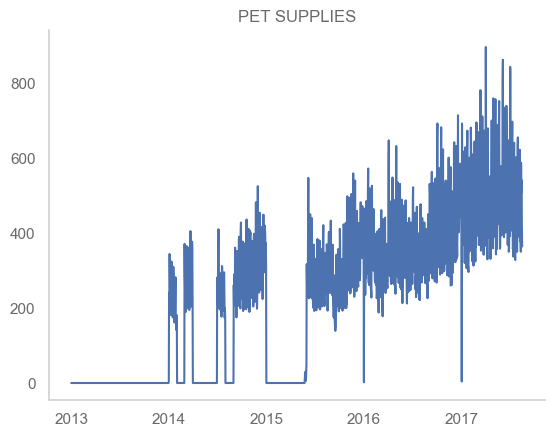

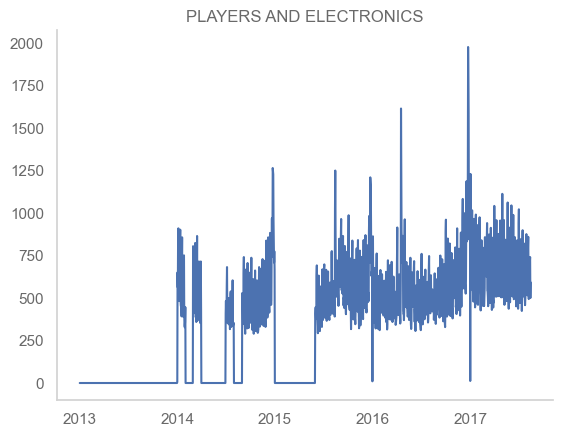

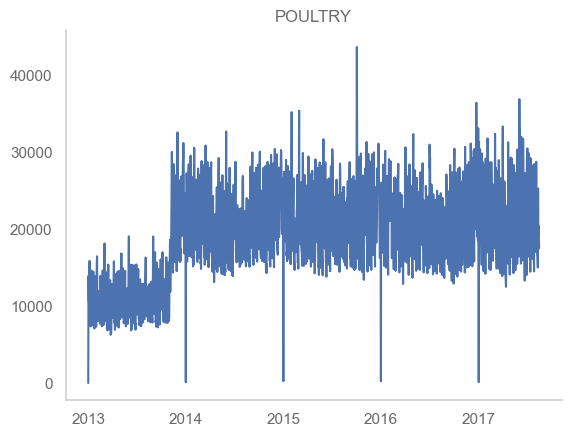

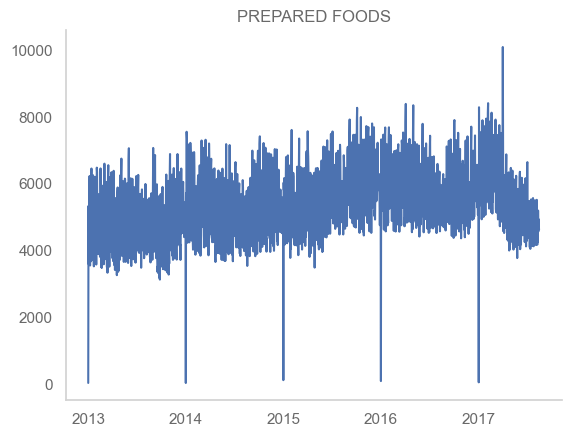

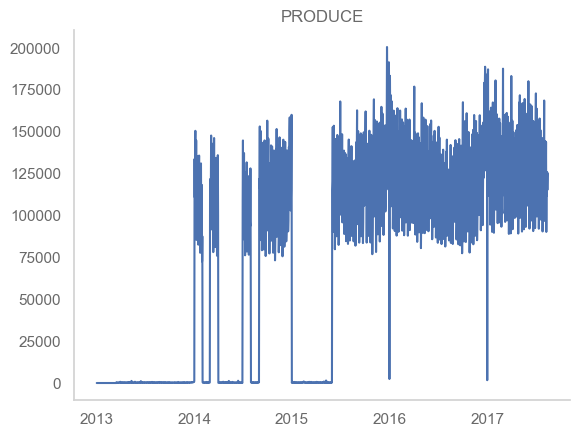

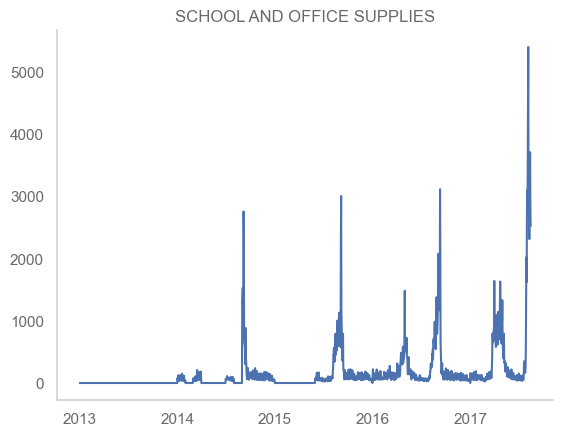

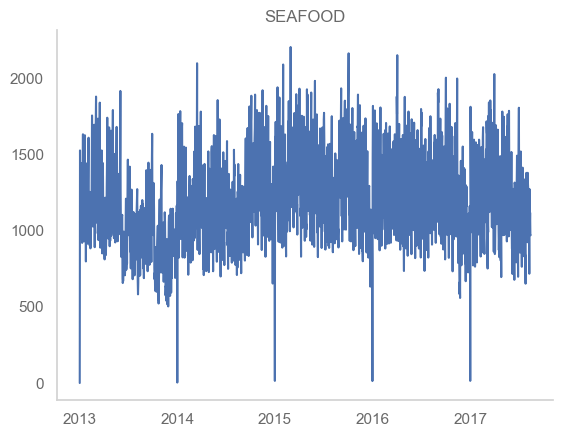

In [40]:
for column in total_sales_df.columns:
    plt.plot(total_sales_df[column])
    plt.title(column)
    plt.show()

In [41]:
total_sales_df = total_sales_df[total_sales_df.index>='2015-08-15']

In [42]:
missing_data(total_sales_df)

,Total,Percent,Types
family,,,
AUTOMOTIVE,0,0.00,float64
BABY CARE,0,0.00,float64
BEAUTY,0,0.00,float64
BEVERAGES,0,0.00,float64
BOOKS,0,0.00,float64
BREAD/BAKERY,0,0.00,float64
CELEBRATION,0,0.00,float64
CLEANING,0,0.00,float64
DAIRY,0,0.00,float64


#### Let's group these different categories by the volume of data. The higher volume data the better for forecasting since you can forecast past the noise and end up with lower error bars. This will also let us visualize the forecasts on similar scales so that we can figure out if timeseries modeling will work for the categories since timeseries highly depends on seasonal data of a certain variation (addtitive, multiplicative).

### Category Grouping

In [43]:
#lets break it down by thirds for low, mid, high
avg_daily_sales = total_sales_df.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(total_sales_df.apply(np.mean, axis=0).sort_values(),[33,66])

In [44]:
low_vol_columns = list(avg_daily_sales[avg_daily_sales<=low].index)
mid_vol_columns = avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index
high_vol_columns = avg_daily_sales[avg_daily_sales>=mid].index

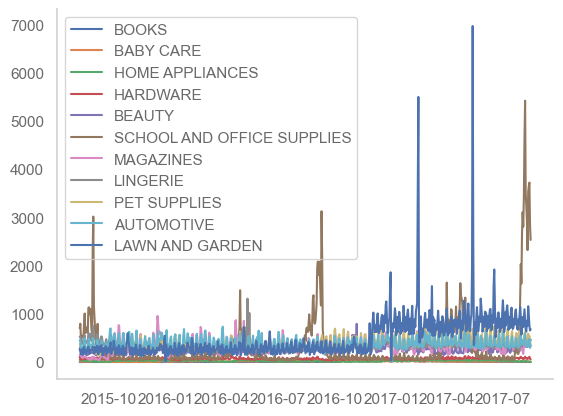

In [45]:
#total_sales_df[low_vol_columns].plot.line()
plt.plot(total_sales_df[low_vol_columns])
plt.legend(low_vol_columns, loc='best') #, bbox_to_anchor=(1.1, 1.1))
plt.show()

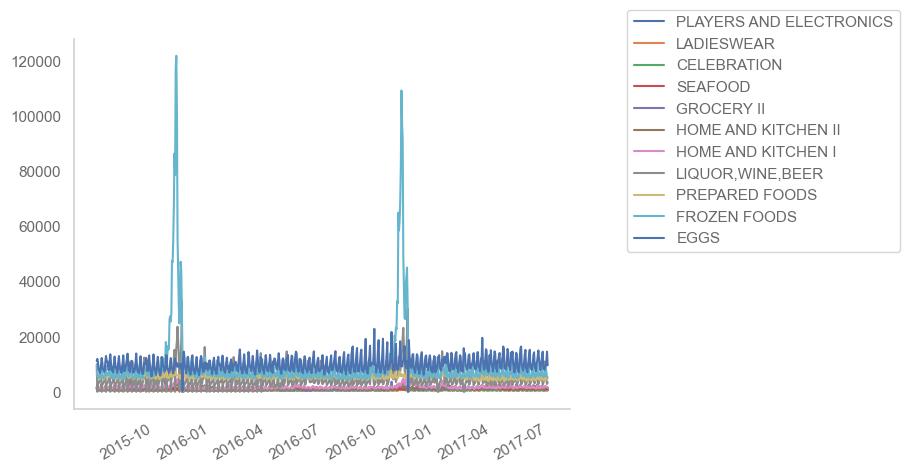

In [46]:
plt.plot(total_sales_df[mid_vol_columns])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

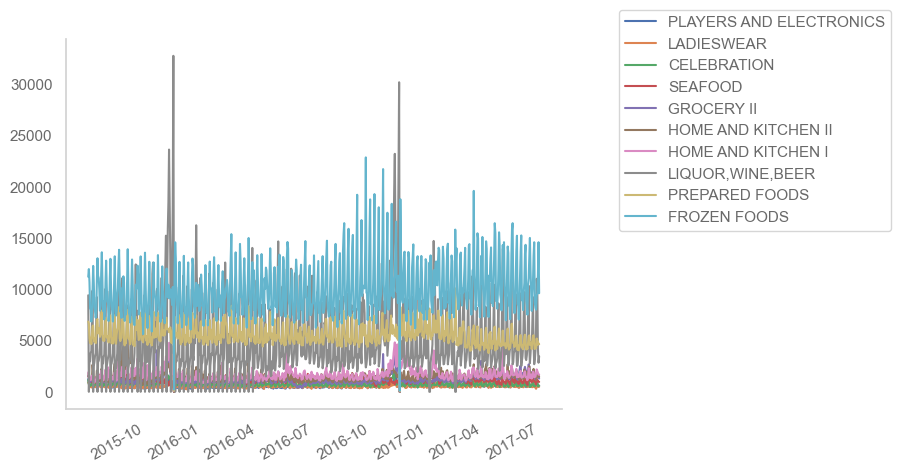

In [47]:
plt.plot(total_sales_df[mid_vol_columns].drop(columns='FROZEN FOODS'))
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

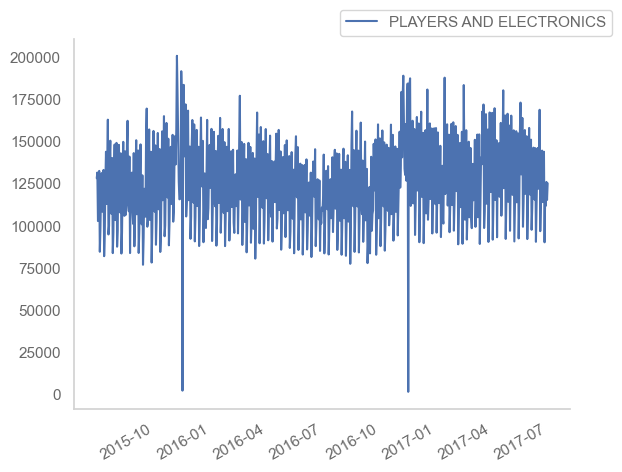

In [48]:
plt.plot(total_sales_df['PRODUCE'])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

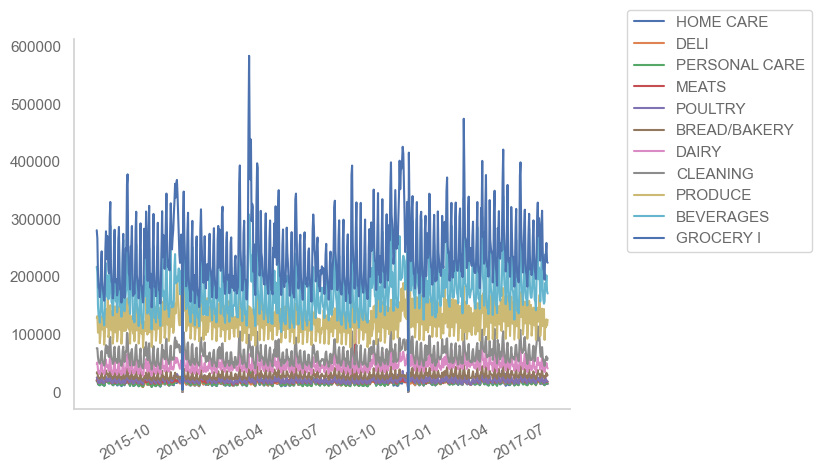

In [49]:
plt.plot(total_sales_df[high_vol_columns])
plt.legend(high_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

### Let's test things out with a high volume metric first to see if things work. Let's test with "PRODUCE."

In [50]:
#setting variables
feature = 'PRODUCE'
prediction_days = 30

In [51]:
df = total_sales_df[[feature]].reset_index()
df.head()

family,date,PRODUCE
0,2015-08-15,128147.18
1,2015-08-16,131493.93
2,2015-08-17,102769.60
3,2015-08-18,106468.23
4,2015-08-19,132449.58


In [52]:
#adding holiday data

holiday = pd.DataFrame([])

ecuador_holidays = holidays.EC()  # this is a dict
# the below is the same, but takes a string:
ecuador_holidays = holidays.country_holidays('EC')  # this is a dict


for date_, name in sorted(holidays.EC(years=[2015,2016,2017,2018]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "EC-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

,ds,holiday,lower_window,upper_window
0,2015-01-01,EC-Holidays,-2,1
1,2015-02-16,EC-Holidays,-2,1
2,2015-02-17,EC-Holidays,-2,1
3,2015-04-03,EC-Holidays,-2,1
4,2015-05-01,EC-Holidays,-2,1


https://pypi.org/project/holidays/

In [53]:
#Variables

forecast_start_dt = date(2017,7,1) #data set ends of (2017,8,15)
forecast_start_date = (forecast_start_dt).strftime("%Y-%m-%d") 
print(forecast_start_date)

2017-07-01


m = Prophet(growth='linear',
            changepoint_range = changepoint_range,
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            seasonality_mode='multiplicative',
            holidays=holiday)

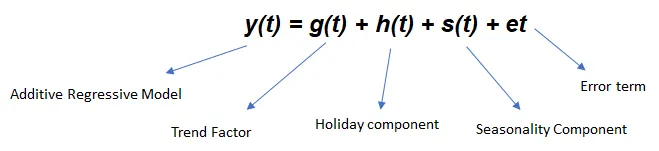

[Timeseries From Scratch article](https://towardsdatascience.com/time-series-from-scratch-decomposing-time-series-data-7b7ad0c30fe7#:~:text=a%20single%20season.-,Multiplicative%20trend%20and%20additive%20seasonality,of%20seasonal%20periods%20over%20time.&text=You%20can%20see%20how%20the%20trend%20is%20slightly%20curved.) will show you the breakdown of the different ways to identify and configure time series parameters for the data you have/business needs utilizing your data.

In [54]:
#PROPHET MODEL

df_copy = df.copy()
df_copy = df_copy.rename(columns={'date': 'ds', feature: 'y'})
df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

df_copy['ds'] = pd.to_datetime(df_copy['ds'])

train_set = df_copy[(df_copy['ds'] < forecast_start_date) ]

m = Prophet()

m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

12:53:21 - cmdstanpy - INFO - Chain [1] start processing
12:53:22 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
predicted_df.head(10)

,ds,yhat
684,2017-07-01,144612.13
685,2017-07-02,155336.04
686,2017-07-03,122383.38
687,2017-07-04,127642.39
688,2017-07-05,160253.27
689,2017-07-06,102667.68
690,2017-07-07,116017.82
691,2017-07-08,144864.32
692,2017-07-09,155588.23
693,2017-07-10,122635.58


<b> variable considerations for prophet model: </b> growth, changepoint_prior_scale, changepoint_range, yearly/weekly/daily seasonality, seasonality mode, holidays

In [56]:
df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)

In [57]:
predicted_df

,ds,yhat,ytrue
0,2017-07-01,144612.13,155487.63
1,2017-07-02,155336.04,172890.14
2,2017-07-03,122383.38,130389.20
3,2017-07-04,127642.39,131534.55
4,2017-07-05,160253.27,163804.33
5,2017-07-06,102667.68,99395.60
6,2017-07-07,116017.82,114346.57
7,2017-07-08,144864.32,139294.77
8,2017-07-09,155588.23,156633.92
9,2017-07-10,122635.58,118856.99


In [58]:
mape(predicted_df['ytrue'], predicted_df['yhat'])

6.2638811231541665

### Cross Validation with Prophet
Find the "best" parameters by testing over various periods of time with those parameters (cross-validation).

In [59]:
m = Prophet()
m.fit(train_set)
df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days')

12:53:22 - cmdstanpy - INFO - Chain [1] start processing
12:53:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/10 [00:00<?, ?it/s]

12:53:22 - cmdstanpy - INFO - Chain [1] start processing
12:53:22 - cmdstanpy - INFO - Chain [1] done processing
12:53:22 - cmdstanpy - INFO - Chain [1] start processing
12:53:22 - cmdstanpy - INFO - Chain [1] done processing
12:53:22 - cmdstanpy - INFO - Chain [1] start processing
12:53:22 - cmdstanpy - INFO - Chain [1] done processing
12:53:22 - cmdstanpy - INFO - Chain [1] start processing
12:53:22 - cmdstanpy - INFO - Chain [1] done processing
12:53:22 - cmdstanpy - INFO - Chain [1] start processing
12:53:22 - cmdstanpy - INFO - Chain [1] done processing
12:53:22 - cmdstanpy - INFO - Chain [1] start processing
12:53:22 - cmdstanpy - INFO - Chain [1] done processing
12:53:22 - cmdstanpy - INFO - Chain [1] start processing
12:53:22 - cmdstanpy - INFO - Chain [1] done processing
12:53:22 - cmdstanpy - INFO - Chain [1] start processing
12:53:22 - cmdstanpy - INFO - Chain [1] done processing
12:53:22 - cmdstanpy - INFO - Chain [1] start processing
12:53:22 - cmdstanpy - INFO - Chain [1]

In [60]:
#total_sales_df[total_sales_df['PRODUCE']<10000]

In [61]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,411911254.07,20295.60,13088.62,0.09,0.07,0.10,0.77
1,4 days,269732789.34,16423.54,11119.74,0.08,0.06,0.08,0.80
2,5 days,141547986.52,11897.39,8894.95,0.07,0.06,0.07,0.87
3,6 days,126310847.91,11238.81,9216.62,0.07,0.07,0.07,0.87
4,7 days,95815198.40,9788.52,8407.64,0.07,0.07,0.07,0.93
5,8 days,75894857.93,8711.77,7674.79,0.06,0.06,0.06,0.97
6,9 days,61122646.17,7818.10,6577.46,0.05,0.04,0.05,1.00
7,10 days,48811966.91,6986.56,5387.81,0.05,0.04,0.05,1.00
8,11 days,78501674.86,8860.12,6694.00,0.05,0.04,0.05,0.97
9,12 days,83261445.28,9124.77,6699.75,0.05,0.05,0.05,0.93


In [62]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,411911254.07,20295.60,13088.62,0.09,0.07,0.10,0.77
1,4 days,269732789.34,16423.54,11119.74,0.08,0.06,0.08,0.80
2,5 days,141547986.52,11897.39,8894.95,0.07,0.06,0.07,0.87
3,6 days,126310847.91,11238.81,9216.62,0.07,0.07,0.07,0.87
4,7 days,95815198.40,9788.52,8407.64,0.07,0.07,0.07,0.93


In [63]:
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
23,26 days,254632370.78,15957.20,12018.61,0.10,0.08,0.10,0.83
24,27 days,305198598.48,17469.93,13245.62,0.11,0.09,0.11,0.80
25,28 days,502076648.26,22407.07,15686.99,0.13,0.08,0.13,0.77
26,29 days,549411933.51,23439.54,16593.94,0.12,0.09,0.13,0.66
27,30 days,1247042864.57,35313.49,21490.91,3.01,0.12,0.19,0.63


df_p gives you the overall MAPE, but if you want to get more granular and calculate the daily differences using the mape metric, the code is below. This allows you to detect issues in predicting certain time periods, which are inherent issues in the data that you may or may not be able to fix. Timeseries is the prime example that garbage in is going to be garbage out.

In [64]:
df_cv['mape'] = (df_cv['y']-df_cv['yhat'])/(df_cv['y'])*100
df_cv['overestimate'] = df_cv['yhat'] > df_cv['y'] 

df_cv.sort_values('mape',ascending=False).head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
110,2016-12-23,98435.33,82628.09,115344.83,176327.97,2016-12-02,44.17,False
116,2016-12-30,98482.55,81951.67,113045.35,175022.19,2016-12-02,43.73,False
109,2016-12-22,87944.49,72296.62,103544.48,140444.94,2016-12-02,37.38,False
119,2017-01-02,117105.88,99761.23,137799.62,184113.03,2017-01-01,36.39,False
120,2017-01-03,121366.40,103207.03,141428.75,183306.23,2017-01-01,33.79,False
111,2016-12-24,127831.67,111671.74,143017.43,188809.16,2016-12-02,32.30,False
117,2016-12-31,127878.90,112790.82,143465.38,184154.67,2016-12-02,30.56,False
115,2016-12-29,87991.72,70096.03,103349.72,126652.84,2016-12-02,30.53,False
238,2017-05-01,126201.34,107638.92,146686.33,167558.58,2017-04-01,24.68,False
108,2016-12-21,143735.72,126702.84,159138.54,179251.71,2016-12-02,19.81,False


In [65]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
0,2016-09-04,137051.97,121227.90,154363.09,144954.39,2016-09-03,5.45,False
1,2016-09-05,103702.40,86396.20,120555.12,110104.68,2016-09-03,5.81,False
2,2016-09-06,107795.45,91113.84,124986.54,115898.16,2016-09-03,6.99,False
3,2016-09-07,140075.90,124709.62,158230.98,142809.15,2016-09-03,1.91,False
4,2016-09-08,84285.75,67067.54,101533.87,85680.68,2016-09-03,1.63,False
5,2016-09-09,93707.67,78606.40,110470.01,96152.02,2016-09-03,2.54,False
6,2016-09-10,123851.91,107521.40,140526.84,128750.47,2016-09-03,3.80,False
7,2016-09-11,136600.82,120434.79,153765.21,142536.23,2016-09-03,4.16,False
8,2016-09-12,103251.24,87717.14,119659.52,102988.54,2016-09-03,-0.26,True
9,2016-09-13,107344.29,91076.10,123619.89,104210.54,2016-09-03,-3.01,True


Optimizing for "PRODUCE" feature. What that means is... <b> lets hypertune this model! </b>

In [66]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = [] 

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_set)  # Fit model with given params
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

12:53:23 - cmdstanpy - INFO - Chain [1] start processing
12:53:23 - cmdstanpy - INFO - Chain [1] done processing
12:53:24 - cmdstanpy - INFO - Chain [1] start processing
12:53:24 - cmdstanpy - INFO - Chain [1] start processing
12:53:24 - cmdstanpy - INFO - Chain [1] start processing
12:53:24 - cmdstanpy - INFO - Chain [1] start processing
12:53:24 - cmdstanpy - INFO - Chain [1] start processing
12:53:24 - cmdstanpy - INFO - Chain [1] start processing
12:53:24 - cmdstanpy - INFO - Chain [1] done processing
12:53:24 - cmdstanpy - INFO - Chain [1] start processing
12:53:24 - cmdstanpy - INFO - Chain [1] done processing
12:53:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:53:24 - cmdstanpy - INFO - Chain [1] done processing
12:53:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:53:24

12:53:30 - cmdstanpy - INFO - Chain [1] done processing
12:53:30 - cmdstanpy - INFO - Chain [1] done processing
12:53:30 - cmdstanpy - INFO - Chain [1] done processing
12:53:30 - cmdstanpy - INFO - Chain [1] done processing
12:53:30 - cmdstanpy - INFO - Chain [1] done processing
12:53:30 - cmdstanpy - INFO - Chain [1] done processing
12:53:30 - cmdstanpy - INFO - Chain [1] start processing
12:53:31 - cmdstanpy - INFO - Chain [1] done processing
12:53:32 - cmdstanpy - INFO - Chain [1] start processing
12:53:32 - cmdstanpy - INFO - Chain [1] done processing
12:53:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:53:32 - cmdstanpy - INFO - Chain [1] start processing
12:53:32 - cmdstanpy - INFO - Chain [1] start processing
12:53:32 - cmdstanpy - INFO - Chain [1] start processing
12:53:32 - cmdstanpy - INFO - Chain [1] done processing
12:53:32 - cmdstanpy - ERROR - Chain [1] error: error d

12:53:41 - cmdstanpy - INFO - Chain [1] done processing
12:53:42 - cmdstanpy - INFO - Chain [1] start processing
12:53:42 - cmdstanpy - INFO - Chain [1] start processing
12:53:42 - cmdstanpy - INFO - Chain [1] start processing
12:53:42 - cmdstanpy - INFO - Chain [1] done processing
12:53:42 - cmdstanpy - INFO - Chain [1] done processing
12:53:42 - cmdstanpy - INFO - Chain [1] start processing
12:53:42 - cmdstanpy - INFO - Chain [1] done processing
12:53:42 - cmdstanpy - INFO - Chain [1] start processing
12:53:42 - cmdstanpy - INFO - Chain [1] start processing
12:53:42 - cmdstanpy - INFO - Chain [1] done processing
12:53:42 - cmdstanpy - INFO - Chain [1] start processing
12:53:42 - cmdstanpy - INFO - Chain [1] start processing
12:53:42 - cmdstanpy - INFO - Chain [1] start processing
12:53:42 - cmdstanpy - INFO - Chain [1] start processing
12:53:42 - cmdstanpy - INFO - Chain [1] done processing
12:53:42 - cmdstanpy - INFO - Chain [1] done processing
12:53:42 - cmdstanpy - INFO - Chain [1

12:53:54 - cmdstanpy - INFO - Chain [1] done processing
12:53:54 - cmdstanpy - INFO - Chain [1] done processing
12:53:54 - cmdstanpy - INFO - Chain [1] done processing
12:53:54 - cmdstanpy - INFO - Chain [1] start processing
12:53:54 - cmdstanpy - INFO - Chain [1] start processing
12:53:54 - cmdstanpy - INFO - Chain [1] done processing
12:53:54 - cmdstanpy - INFO - Chain [1] done processing
12:53:54 - cmdstanpy - INFO - Chain [1] done processing
12:53:54 - cmdstanpy - INFO - Chain [1] start processing
12:53:55 - cmdstanpy - INFO - Chain [1] done processing
12:53:56 - cmdstanpy - INFO - Chain [1] start processing
12:53:56 - cmdstanpy - INFO - Chain [1] start processing
12:53:56 - cmdstanpy - INFO - Chain [1] done processing
12:53:56 - cmdstanpy - INFO - Chain [1] start processing
12:53:56 - cmdstanpy - INFO - Chain [1] start processing
12:53:56 - cmdstanpy - INFO - Chain [1] start processing
12:53:56 - cmdstanpy - INFO - Chain [1] done processing
12:53:56 - cmdstanpy - INFO - Chain [1] 

In [67]:
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale     rmse
0                      0.00                     0.01 18782.74
1                      0.00                     0.10 18893.21
2                      0.00                     1.00 18530.96
3                      0.00                    10.00 18650.23
4                      0.01                     0.01 18185.61
5                      0.01                     0.10 17779.54
6                      0.01                     1.00 17756.78
7                      0.01                    10.00 17722.73
8                      0.10                     0.01 18096.29
9                      0.10                     0.10 17727.24
10                     0.10                     1.00 17714.22
11                     0.10                    10.00 17712.65
12                     0.50                     0.01 18098.10
13                     0.50                     0.10 17752.96
14                     0.50                     1.00 17759.66
15      

In [68]:
tuning_results.sort_values('rmse')

,changepoint_prior_scale,seasonality_prior_scale,rmse
11,0.10,10.00,17712.65
10,0.10,1.00,17714.22
7,0.01,10.00,17722.73
9,0.10,0.10,17727.24
13,0.50,0.10,17752.96
6,0.01,1.00,17756.78
14,0.50,1.00,17759.66
15,0.50,10.00,17772.76
5,0.01,0.10,17779.54
8,0.10,0.01,18096.29


In [69]:
tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0]

changepoint_prior_scale       0.10
seasonality_prior_scale      10.00
rmse                      17712.65
Name: 0, dtype: float64

In [70]:
dict(tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0])

{'changepoint_prior_scale': 0.1,
 'seasonality_prior_scale': 10.0,
 'rmse': 17712.6503315396}

In [71]:
params_dictionary = dict(tuning_results.sort_values('rmse').reset_index(drop=True).drop('rmse',axis='columns').iloc[0])

m = Prophet(changepoint_prior_scale = params_dictionary['changepoint_prior_scale'], 
            seasonality_prior_scale = params_dictionary['seasonality_prior_scale'])


In [72]:
m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)
mape(predicted_df['ytrue'], predicted_df['yhat'])

12:53:56 - cmdstanpy - INFO - Chain [1] start processing
12:53:57 - cmdstanpy - INFO - Chain [1] done processing


4.930856525244661

## Demand Forecasting Pipeline
<b> Day 2: Creating robust pipeline that further optimizes and predicts for each category
<p> Please check Priya Lingutla's GitHub for that full notebook.